In [3]:
%matplotlib inline

import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt

In [4]:
def state_space_control_model(data, N=1, T=2, p=2, u=None):
    """
    :param data: (torch.tensor or None) data of shape (T - 1, N, p) or None if prior
    :param N: (int) number of observations
    :param T: (int) number of timesteps
    :param p: (int) dimensionality of data
    :param u: (torch.tensor or None) control if observed, or None if control is to be inferred
    """
    assert (type(p) is int) and (type(N) is int) and (type(T) is int)
    assert (p > 0) and (N > 0) and (T > 0)
    
    # endogenous dynamics
    A = pyro.sample(
        "A",
        dist.Normal(0, 0.1).expand((p, p))
    )
    # control effect
    B = pyro.sample(
        "B",
        dist.Normal(0, 0.1).expand((p, p))
    )
    
    # various noise distributions
    eta = pyro.sample(
        "eta",
        dist.LogNormal(0, 1)
    )
    state_correlation = pyro.sample(
        "state_correlation",
        dist.LKJCorrCholesky(p, eta)
    )
    obs_correlation = pyro.sample(
        "obs_correlation",
        dist.LKJCorrCholesky(p, eta)
    )
    state_std = pyro.sample(
        "state_std",
        dist.LogNormal(0, 1).expand((p,))
    )
    obs_std = pyro.sample(
        "obs_std",
        dist.LogNormal(-2, 1).expand((p,))
    )
    state_cov_tril = torch.mm(torch.diag(state_std), state_correlation)
    obs_cov_tril = torch.mm(torch.diag(obs_std), obs_correlation)
    
    if u is None:
        controls = torch.empty((T, N, p))
    latents = torch.empty((T, N, p))
    
    data_plate = pyro.plate("data_plate", N)
    time_markov = pyro.markov(range(1, T))
    
    with data_plate as n:
        z_0 = pyro.sample(
            "z_0",
            dist.MultivariateNormal(torch.zeros(p), scale_tril=state_cov_tril)
        )
        latents[0] = z_0
        if u is None:
            u_0 = pyro.sample(
                "u_0",
                dist.MultivariateNormal(torch.zeros(p), scale_tril=state_cov_tril)
            )
            controls[0] = u_0
        
        for t in time_markov:
            # z[t] = z[t-1] * A + u[t-1] * B + e[t], e[t] ~ MultivariateNormal(...)
            # x[t] = z[t] + w[t], w[t] ~ MultivariateNormal(...)
            # if controls aren't passed, assume random walk prior for them, so
            # u[t] = u[t-1] + b[t], b[t] ~ MultivariateNormal(...)
            if u is None:
                u_t = pyro.sample(
                    f"u_{t}",
                    dist.MultivariateNormal(controls[t - 1], scale_tril=state_cov_tril)
                )
                this_u = u_t
                controls[t] = this_u
            else:
                this_u = u[t - 1]
            z_t = pyro.sample(
                "z_t",
                dist.MultivariateNormal(
                    torch.matmul(latents[t - 1], A) + torch.matmul(this_u, B),
                    scale_tril=state_cov_tril
                )
            )
            latents[t] = z_t
            x_t = pyro.sample(
                "x_t",
                dist.MultivariateNormal(z_t, scale_tril=obs_cov_tril),
                obs=data[t - 1] if data is not None else None
            )
    if u is None:
        return latents, controls
    return latents

In [7]:
SEED = 2
torch.manual_seed(SEED)
pyro.set_rng_seed(SEED)

latents, controls = state_space_control_model(None, T=100, p=4)

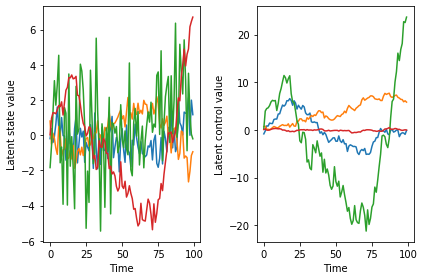

In [8]:
fig, axes = plt.subplots(1, 2)
ax, ax2 = axes
ax.plot(latents.squeeze())
ax2.plot(controls.squeeze())
ax.set_xlabel("Time")
ax2.set_xlabel("Time")
ax.set_ylabel("Latent state value")
ax2.set_ylabel("Latent control value")
plt.tight_layout()
plt.savefig("./figures/example-var-control.png")